In [1]:
import pandas as pd
import numpy as np
import csv
import statsmodels.api as sm
import os

In [2]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [3]:
import dotenv

# Load the environment variables
# (loads CENSUS_API_KEY from .env)
dotenv.load_dotenv()

False

In [4]:
%%R
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In addition: Warning messages:
1: package ‘readr’ was built under R version 4.2.3 
2: package ‘dplyr’ was built under R version 4.2.3 
3: package ‘stringr’ was built under R version 4.2.3 


In [5]:
# Open the file and turn it into a pandas dataframe
df = pd.read_csv('Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')

# Show the first 5 rows of the dataframe
print(df.head())

   RegionID  SizeRank  RegionName RegionType StateName State      City  \
0     91982         1       77494        zip        TX    TX      Katy   
1     61148         2        8701        zip        NJ    NJ  Lakewood   
2     91940         3       77449        zip        TX    TX      Katy   
3     62080         4       11368        zip        NY    NY  New York   
4     91733         5       77084        zip        TX    TX   Houston   

                                   Metro        CountyName     2000-01-31  \
0   Houston-The Woodlands-Sugar Land, TX  Fort Bend County  210077.000246   
1  New York-Newark-Jersey City, NY-NJ-PA      Ocean County  137227.265500   
2   Houston-The Woodlands-Sugar Land, TX     Harris County  103358.701090   
3  New York-Newark-Jersey City, NY-NJ-PA     Queens County  146558.052897   
4   Houston-The Woodlands-Sugar Land, TX     Harris County  102016.821579   

   ...     2023-05-31     2023-06-30     2023-07-31     2023-08-31  \
0  ...  474580.751007 

In [6]:
# Print the column names
print(df.columns)

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'City', 'Metro', 'CountyName', '2000-01-31',
       ...
       '2023-05-31', '2023-06-30', '2023-07-31', '2023-08-31', '2023-09-30',
       '2023-10-31', '2023-11-30', '2023-12-31', '2024-01-31', '2024-02-29'],
      dtype='object', length=299)


In [7]:
# Keep only data with State as MA
df = df[df['State'] == 'CA']

# Keep only columns including RegionName, StateName, City, Metro, CountyName, 31/12/2018, 31/12/2019, 31/12/2022, 31/12/2023
df = df[['RegionName', 'StateName', 'City', 'Metro', 'CountyName', '2018-12-31', '2019-12-31', '2022-12-31', '2023-12-31']]

In [8]:
# Ditch the rows with NaN values
df = df.dropna()

# Show how many rows are left
print(df.shape)

(1400, 9)


In [9]:
df['RegionName'] = df['RegionName'].astype(str).str.zfill(5)

In [10]:
# Show the first 5 rows of RegionName
print(df['RegionName'].head())

9     90011
12    90650
13    91331
21    90044
22    92336
Name: RegionName, dtype: object


In [11]:
# Store all the RegionNames in a list
ca_zips = df['RegionName'].tolist()

In [12]:
%%R 

require('tidycensus')

# because it an environment variable, we don't have to 
# explicitly pass this string to R, it is readable here
# in this R cell.
census_api_key(Sys.getenv("97779d587a8fdba4e4f7f7d3eec838313d5b07ab"))

Loading required package: tidycensus
To install your API key for use in future sessions, run this function with `install = TRUE`.
In addition: Warning message:
package ‘tidycensus’ was built under R version 4.2.3 


In [13]:
%%R 
# Get variable from ACS
ca_census_data_2022 <- get_acs(geography = "zip code tabulation area",
                      variables = c(
                        total_population_2022 = "B01003_001",
                        median_room_2022 = "B25018_001",
                        median_built_2022 = "B25035_001",
                        median_income_2022 = "B06011_001",
                        bachelor_2022 = "B15003_022",
                        asian_2022 = "B03002_006", 
                        black_2022 = "B03002_004",
                        hispanic_2022 = "B03002_012"
                      ), 
                      year = 2022,
                      survey="acs5",
                      geometry=F)
ca_census_data_2022

# A tibble: 270,192 × 5
   GEOID NAME        variable              estimate   moe
   <chr> <chr>       <chr>                    <dbl> <dbl>
 1 00601 ZCTA5 00601 total_population_2022    16834   506
 2 00602 ZCTA5 00602 total_population_2022    37642   205
 3 00603 ZCTA5 00603 total_population_2022    49075   963
 4 00606 ZCTA5 00606 total_population_2022     5590   264
 5 00610 ZCTA5 00610 total_population_2022    25542   344
 6 00611 ZCTA5 00611 total_population_2022     1315   382
 7 00612 ZCTA5 00612 total_population_2022    63312  1805
 8 00616 ZCTA5 00616 total_population_2022     9625  1319
 9 00617 ZCTA5 00617 total_population_2022    22573   241
10 00622 ZCTA5 00622 total_population_2022     7577   979
# ℹ 270,182 more rows
# ℹ Use `print(n = ...)` to see more rows


Getting data from the 2018-2022 5-year ACS
In addition: Warning message:
• You have not set a Census API key. Users without a key are limited to 500
queries per day and may experience performance limitations.
ℹ For best results, get a Census API key at
http://api.census.gov/data/key_signup.html and then supply the key to the
`census_api_key()` function to use it throughout your tidycensus session.
This warning is displayed once per session. 


In [14]:
%R -i ca_zips

ca_zips

['90011',
 '90650',
 '91331',
 '90044',
 '92336',
 '94565',
 '92335',
 '90201',
 '90250',
 '90805',
 '93307',
 '90280',
 '91342',
 '92683',
 '92503',
 '92345',
 '91911',
 '93033',
 '95076',
 '92154',
 '92376',
 '92804',
 '91710',
 '93722',
 '94112',
 '95823',
 '95035',
 '91744',
 '92509',
 '93257',
 '93550',
 '92592',
 '95630',
 '92880',
 '94544',
 '90706',
 '93535',
 '92704',
 '93274',
 '91335',
 '94533',
 '93536',
 '91709',
 '91910',
 '94513',
 '93727',
 '91706',
 '90003',
 '92126',
 '92553',
 '93306',
 '93230',
 '95747',
 '94536',
 '92563',
 '90255',
 '92105',
 '92021',
 '91730',
 '94110',
 '94509',
 '93065',
 '95687',
 '92882',
 '94558',
 '94538',
 '91766',
 '92805',
 '90631',
 '90026',
 '94587',
 '92801',
 '95624',
 '91402',
 '95123',
 '92114',
 '94541',
 '90262',
 '90037',
 '92407',
 '93906',
 '94080',
 '92703',
 '95020',
 '92404',
 '90022',
 '91761',
 '91977',
 '92677',
 '92630',
 '95758',
 '92346',
 '90731',
 '95206',
 '95608',
 '91343',
 '92201',
 '92562',
 '94806',
 '92392',


In [15]:
%%R
# Remove the "ZCTA5 " prefix from the NAME column
ca_census_data_2022$NAME <- sub("ZCTA5 ", "", ca_census_data_2022$NAME)

# Show the first 5 rows of the ma_census_data_2022 dataframe
head(ca_census_data_2022)

# A tibble: 6 × 5
  GEOID NAME  variable              estimate   moe
  <chr> <chr> <chr>                    <dbl> <dbl>
1 00601 00601 total_population_2022    16834   506
2 00602 00602 total_population_2022    37642   205
3 00603 00603 total_population_2022    49075   963
4 00606 00606 total_population_2022     5590   264
5 00610 00610 total_population_2022    25542   344
6 00611 00611 total_population_2022     1315   382


In [16]:
%%R
# Keep only the rows with RegionName in ma_zips
ca_census_data_2022 <- ca_census_data_2022[ca_census_data_2022$NAME %in% ca_zips,]

# Show the first 5 rows of the ma_census_data_2022 dataframe
head(ca_census_data_2022)

# A tibble: 6 × 5
  GEOID NAME  variable              estimate   moe
  <chr> <chr> <chr>                    <dbl> <dbl>
1 90001 90001 total_population_2022    57652  2615
2 90002 90002 total_population_2022    53108  2472
3 90003 90003 total_population_2022    75024  3354
4 90004 90004 total_population_2022    58833  2270
5 90005 90005 total_population_2022    37754  2108
6 90006 90006 total_population_2022    56628  2531


In [17]:
%%R
# Ditch NAME and moe columns
ca_census_data_2022 <- ca_census_data_2022 %>%
  select(-NAME, -moe)

In [18]:
%%R
# Convert the long format to wide format
ca_census_data_2022_wide <- ca_census_data_2022 %>%
  pivot_wider(
    names_from = variable,  # Column that contains variable names
    values_from = estimate  # Column that contains the values
  )

# Show the first 5 rows of the ma_census_data_2022 dataframe
head(ca_census_data_2022_wide)

# A tibble: 6 × 9
  GEOID total_population_2022 median_room_2022 median_built_2022
  <chr>                 <dbl>            <dbl>             <dbl>
1 90001                 57652              4.5              1950
2 90002                 53108              4.7              1953
3 90003                 75024              4.6              1955
4 90004                 58833              3.3              1959
5 90005                 37754              2.7              1961
6 90006                 56628              3                1953
# ℹ 5 more variables: median_income_2022 <dbl>, bachelor_2022 <dbl>,
#   asian_2022 <dbl>, black_2022 <dbl>, hispanic_2022 <dbl>


In [19]:
%%R
df <- read.csv("Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv")

# Fill the RegionName to 5 digits
df$RegionName <- as.character(df$RegionName)
df$RegionName <- sprintf("%05s", df$RegionName)

# Keep only data with State as MA
df <- df[df$State == 'CA',]

# Show the first 5 rows of the dataframe
head(df)

   RegionID SizeRank RegionName RegionType StateName State        City
10    95992       10      90011        zip        CA    CA Los Angeles
13    96193       13      90650        zip        CA    CA     Norwalk
14    96361       14      91331        zip        CA    CA Los Angeles
22    96025       22      90044        zip        CA    CA Los Angeles
23    96817       23      92336        zip        CA    CA     Fontana
24    97771       24      94565        zip        CA    CA   Pittsburg
                                  Metro            CountyName X2000.01.31
10   Los Angeles-Long Beach-Anaheim, CA    Los Angeles County    118461.3
13   Los Angeles-Long Beach-Anaheim, CA    Los Angeles County    156833.5
14   Los Angeles-Long Beach-Anaheim, CA    Los Angeles County    124540.0
22   Los Angeles-Long Beach-Anaheim, CA    Los Angeles County    129868.6
23 Riverside-San Bernardino-Ontario, CA San Bernardino County    164352.9
24   San Francisco-Oakland-Berkeley, CA   Contra Costa Coun

In [20]:
%%R
# How many rows are left
nrow(df)

[1] 1544


In [21]:
%%R

# Append the X2022.12.31 column to the ma_census_data_2022_wide dataframe
# With RegionName in df matching GEOID in ma_census_data_2022_wide. Only keep the rows with a match.

ca_census_data_2022_wide <- ca_census_data_2022_wide %>%
    inner_join(df, by = c('GEOID' = 'RegionName'))

# Show the first 5 rows of the ma_census_data_2022_wide dataframe
head(ca_census_data_2022_wide)

# A tibble: 6 × 307
  GEOID total_population_2022 median_room_2022 median_built_2022
  <chr>                 <dbl>            <dbl>             <dbl>
1 90001                 57652              4.5              1950
2 90002                 53108              4.7              1953
3 90003                 75024              4.6              1955
4 90004                 58833              3.3              1959
5 90005                 37754              2.7              1961
6 90006                 56628              3                1953
# ℹ 303 more variables: median_income_2022 <dbl>, bachelor_2022 <dbl>,
#   asian_2022 <dbl>, black_2022 <dbl>, hispanic_2022 <dbl>, RegionID <int>,
#   SizeRank <int>, RegionType <chr>, StateName <chr>, State <chr>, City <chr>,
#   Metro <chr>, CountyName <chr>, X2000.01.31 <dbl>, X2000.02.29 <dbl>,
#   X2000.03.31 <dbl>, X2000.04.30 <dbl>, X2000.05.31 <dbl>, X2000.06.30 <dbl>,
#   X2000.07.31 <dbl>, X2000.08.31 <dbl>, X2000.09.30 <dbl>, X2000.10.31 <dbl>,

In [22]:
%%R

# Create a new column named bachelor_rate_2022, which is the ratio of bachelor_2022 to total_population_2022
ca_census_data_2022_wide <- ca_census_data_2022_wide %>%
    mutate(bachelor_rate_2022 = bachelor_2022 / total_population_2022)

# Create a new column named asian_rate_2022, which is the ratio of asian_2022 to total_population_2022
ca_census_data_2022_wide <- ca_census_data_2022_wide %>%
    mutate(asian_rate_2022 = asian_2022 / total_population_2022)

# Create a new column named black_rate_2022, which is the ratio of black_2022 to total_population_2022
ca_census_data_2022_wide <- ca_census_data_2022_wide %>%
    mutate(black_rate_2022 = black_2022 / total_population_2022)

# Create a new column named hispanic_rate_2022, which is the ratio of hispanic_2022 to total_population_2022
ca_census_data_2022_wide <- ca_census_data_2022_wide %>%
    mutate(hispanic_rate_2022 = hispanic_2022 / total_population_2022)

In [23]:
%%R

# Create a new df, which includes the following columns from ma_census_data_2022_wide:
# GEOID, total_population_2022, median_room_2022, median_built_2022, median_income_2022, bachelor_rate_2022, asian_rate_2022, black_rate_2022, hispanic_rate_2022, X2022.12.31
df_final <- ca_census_data_2022_wide %>%
    select(GEOID, total_population_2022, median_room_2022, median_built_2022, median_income_2022, bachelor_rate_2022, asian_rate_2022, black_rate_2022, hispanic_rate_2022, X2022.12.31)

# Show the first 5 rows of the df_final dataframe
head(df_final)

# A tibble: 6 × 10
  GEOID total_population_2022 median_room_2022 median_built_2022
  <chr>                 <dbl>            <dbl>             <dbl>
1 90001                 57652              4.5              1950
2 90002                 53108              4.7              1953
3 90003                 75024              4.6              1955
4 90004                 58833              3.3              1959
5 90005                 37754              2.7              1961
6 90006                 56628              3                1953
# ℹ 6 more variables: median_income_2022 <dbl>, bachelor_rate_2022 <dbl>,
#   asian_rate_2022 <dbl>, black_rate_2022 <dbl>, hispanic_rate_2022 <dbl>,
#   X2022.12.31 <dbl>


In [24]:
%%R

# Run a multiple linear regression model with X2022.12.31 as the dependent variable
# and the other columns as the independent variables

model <- lm(X2022.12.31 ~ total_population_2022 + median_room_2022 + median_built_2022 + median_income_2022 + bachelor_rate_2022 + asian_rate_2022 + black_rate_2022 + hispanic_rate_2022, data = df_final)

# Show the summary of the model
summary(model)


Call:
lm(formula = X2022.12.31 ~ total_population_2022 + median_room_2022 + 
    median_built_2022 + median_income_2022 + bachelor_rate_2022 + 
    asian_rate_2022 + black_rate_2022 + hispanic_rate_2022, data = df_final)

Residuals:
     Min       1Q   Median       3Q      Max 
-1982084  -183546   -38510   113680  5266719 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            1.976e+07  1.679e+06  11.770  < 2e-16 ***
total_population_2022  2.764e-02  5.909e-01   0.047  0.96270    
median_room_2022       9.956e+04  1.432e+04   6.954 5.46e-12 ***
median_built_2022     -1.043e+04  8.557e+02 -12.191  < 2e-16 ***
median_income_2022     1.828e+01  9.318e-01  19.624  < 2e-16 ***
bachelor_rate_2022     1.641e+06  2.332e+05   7.037 3.09e-12 ***
asian_rate_2022        3.353e+05  9.270e+04   3.616  0.00031 ***
black_rate_2022       -3.753e+05  1.795e+05  -2.091  0.03671 *  
hispanic_rate_2022     2.822e+05  6.986e+04   4.039 5.67e-05 ***
---
Signi

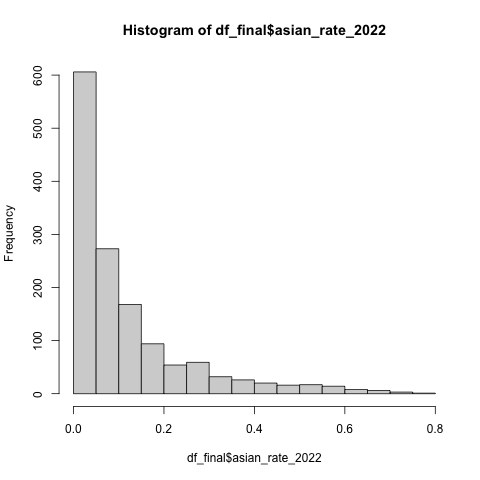

In [25]:
%%R

# Create a histogram of asian_rate_2022
hist(df_final$asian_rate_2022)